# Homework 1 Problem 2 Part 2

We'll first implement a helper function to calculate sigmoid.

In [ ]:
import numpy as np

def sigmoid_scalar(z):
  return 1/(1+np.e**(-z))

Now we'll add a method to support sigmoid to the `Value` class. I put mine after ReLU.

In [ ]:
import random

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data = None, _children=(), _op=''):
        if data is None:
          data = random.uniform(-1,1)
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc
    
    def backward(self):
        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()


    # Arithmetic operations 

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
# In first reading you can ignore all code below here - if you understand everything above then you undestand the main concepts        
##############################################################################################################################

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out
    
    def sigmoid(self):
        sigma_z = sigmoid_scalar(self.data)        
        out = Value(sigma_z)

        def _backward():
            self.grad += out.grad * sigma_z * (1-sigma_z)
        out._backward = _backward

        return out

    # Other operations implemented in terms of prior ones 
    def __float__(self): return float(self.data)
    def __neg__(self): return self * -1
    def __radd__(self, other): return self + other
    def __sub__(self, other):  return self + (-other)
    def __rsub__(self, other): return other + (-self)
    def __rmul__(self, other): return self * other
    def __truediv__(self, other): return self * other**-1
    def __rtruediv__(self, other): return other * self**-1
    def __repr__(self): return f"Value(data={self.data}, grad={self.grad})"

### Sigmoid on the moons dataset

We'll do everything in the demo except with a modified architecture.

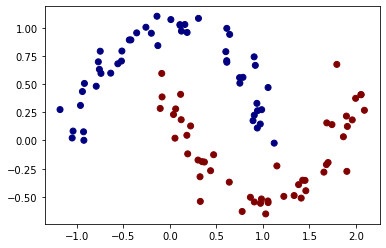

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs
X, Y = make_moons(n_samples=100, noise=0.1)
Y = 2*Y - 1 # go from {0,1} to {-1, 1}

plt.scatter(X[:,0],X[:,1], c=Y, cmap='jet')
plt.show()

This is where the ReLU to sigmoid modification goes.

In [ ]:
def neuron(weights, inputs, sigmoid=True): # MODIFY THIS LINE
  v = sum(w*x for w,x in zip(weights, inputs))
  return v.sigmoid() if sigmoid else v # MODIFY THIS LINE

class Net:
  # The list comprehension is fancy but this is exactly the architecture
  # we've been drawing in class.
  def __init__(self, hidden_dim=16):
    self.layer_1 = [[Value(), Value()] for i in range(hidden_dim)]
    self.layer_2 = [[Value() for j in range(hidden_dim)] for i in range(hidden_dim)]
    self.output = [Value() for i in range(hidden_dim)]
    self.parameters = [v for L in [self.layer_1,self.layer_2,[self.output]] for w in L for v in w]
  
  def __call__(self, x):
    layer_1_vals = [neuron(w,x) for w in self.layer_1]
    layer_2_vals = [neuron(w, layer_1_vals) for w in self.layer_2]
    return neuron(self.output, layer_2_vals, sigmoid=False) # MODIFY THIS LINE
  
  def zero_grad(self):
    for p in self.parameters:
      p.grad = 0

We'll use the following helper function to visualize how our model is doing.

In [ ]:
import numpy as np
from IPython.display import clear_output

def plot_prediction(X, Y, model, title=None, h=.5):
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))
  Xmesh = np.c_[xx.ravel(), yy.ravel()]
  inputs = [list(map(Value, xrow)) for xrow in Xmesh]
  scores = list(map(model, inputs))
  Z = np.array([s.data > 0 for s in scores])
  Z = Z.reshape(xx.shape)
  
  fig = plt.figure()
  clear_output()
  if title != None: plt.title(title)
  plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
  plt.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.Spectral)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())
  plt.show()

Now let's train our architecture using gradient descent. Notice we're using a slighty non-standard loss. In particular, we want our prediction $y'$ to be close to the true value $y$. In math notation, we want $y y' =1$ so our loss is $1-y y'$. The problem is the model may output really large weights to make this really negative so we need to bound the loss from below at 0.

In [ ]:
model = Net(20)

num_epochs = 30
learning_rate = 1
for epoch in range(num_epochs): 
  loss = 0
  for x,y in zip(X,Y):
    output = model(x)
    # want y*output = 1
    # set lowest loss at 0
    loss += (1 + -y*output).relu() # we will KEEP the relu here
    # The reasoning is that it serves a different purpose of
    # lower bounding the loss we could achieve at 0. 
  loss = loss/len(X) # normalize
  model.zero_grad()
  loss.backward()
  for p in model.parameters:
    p.data -= learning_rate * p.grad   
  accuracy = sum(float(model(x))*y > 0 for x,y in zip(X,Y))/len(X)  
  message = f'Epoch: {epoch}, Loss: {round(loss.data, 2)},  Accuracy: {accuracy*100}'
  print(message)

Epoch: 0, Loss: 1.0,  Accuracy: 50.0
Epoch: 1, Loss: 0.97,  Accuracy: 50.0
Epoch: 2, Loss: 0.95,  Accuracy: 50.0
Epoch: 3, Loss: 0.92,  Accuracy: 57.99999999999999
Epoch: 4, Loss: 0.9,  Accuracy: 57.99999999999999
Epoch: 5, Loss: 0.87,  Accuracy: 70.0
Epoch: 6, Loss: 0.85,  Accuracy: 69.0
Epoch: 7, Loss: 0.82,  Accuracy: 61.0
Epoch: 8, Loss: 0.8,  Accuracy: 62.0
Epoch: 9, Loss: 0.77,  Accuracy: 63.0


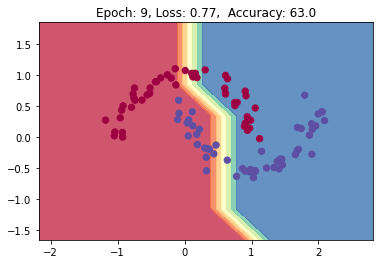

In [ ]:
plot_prediction(X, Y, model, title=message, h=.5)

Our model appears to be doing much much worse with sigmoid. Perhaps this is because we need the sharp cut off to learn the boundary of the data. Of course, with many neurons we would be able to learn the function better but we are limited by the inefficient backpropagation code.